# Final Project: League of Legends Match Predictor 


### Introduction  

League of Legends, a popular multiplayer online battle arena (MOBA) game, generates extensive data from matches, providing an excellent opportunity to apply machine learning techniques to real-world scenarios. 

#### Goal: 
Building a logistic regression model aimed at predicting the outcomes of League of Legends matches.  

Data Source: [league_of_legends_data_large.csv](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rk7VDaPjMp1h5VXS-cUyMg/league-of-legends-data-large.csv)  

### Step 1: Data Loading and Preprocessing  

In [113]:
import pandas as pd
import numpy as np
import torch
from torch import nn,optim
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import Accuracy
from torch.utils.data import TensorDataset , DataLoader

In [114]:
#Loading data and taking a look at the first 5 rows
data = pd.read_csv('league-of-legends-data-large.csv')
data.head()

,win,kills,deaths,assists,gold_earned,cs,wards_placed,wards_killed,damage_dealt
0,0,16,6,19,17088,231,11,7,15367
1,1,8,8,5,14865,259,10,2,38332
2,0,0,17,11,15919,169,14,5,24642
3,0,19,11,1,11534,264,14,3,15789
4,0,12,7,6,18926,124,15,7,40268


In [115]:
#Check if any data is missed
data.isnull().sum()

win             0
kills           0
deaths          0
assists         0
gold_earned     0
cs              0
wards_placed    0
wards_killed    0
damage_dealt    0
dtype: int64

In [116]:
#Specifying features and target
features_columns = [col for col in data.columns if col!='win']
features = data[features_columns]
target = data['win']
features.head()

,kills,deaths,assists,gold_earned,cs,wards_placed,wards_killed,damage_dealt
0,16,6,19,17088,231,11,7,15367
1,8,8,5,14865,259,10,2,38332
2,0,17,11,15919,169,14,5,24642
3,19,11,1,11534,264,14,3,15789
4,12,7,6,18926,124,15,7,40268


In [117]:
#Split dataset
X_train, X_test, Y_train,Y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)


#Feature Scaling
scale_method = StandardScaler()
#call fit_tranform, fit:  function to calculate mean and std of X_train and transofrm: to convert data
X_train_scaled = scale_method.fit_transform(X_train)
#Use same scalar to transform test data (so no fit is needed)
X_test_scaled = scale_method.transform(X_test)


#Converting DataFrame data to tensor
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)  #X_train_scaled is already numpy.ndarray 
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)  
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32)   #df.values to convert df to numpy
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32)

# print(X_train_scaled_tensor.dtype)
# print(Y_train_tensor.dtype)
#make train/test datasets
train_dataset = TensorDataset(X_train_scaled_tensor,Y_train_tensor)
test_dataset = TensorDataset(X_test_scaled_tensor,Y_test_tensor)

#make dataloader
train_loader = DataLoader(dataset= train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(dataset= test_dataset, batch_size=2, shuffle=False)

### Step 2: Logistic Regression Model  

In [118]:
#create model class
class LogisticRegressionModel(nn.Module):
    #Constructor
    def __init__(self, input_size, output_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size , output_size)

    #prediction
    def forward(self,x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

#create model object
model = LogisticRegressionModel(X_train_scaled_tensor.shape[1],1)

#create cost function
criterion = nn.BCELoss()

#Optimizer
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(),lr = learning_rate)

print(f'Number of features: {X_train_scaled_tensor.shape[1]}')
print(f'Model parameters: {list(model.parameters())}')
print(f' Logistic Regression Model is :{model}')

Number of features: 8
Model parameters: [Parameter containing:
tensor([[ 0.3054, -0.2313, -0.0219, -0.2883, -0.0133,  0.1606, -0.1053, -0.2916]],
       requires_grad=True), Parameter containing:
tensor([0.2125], requires_grad=True)]
 Logistic Regression Model is :LogisticRegressionModel(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)


### Step 3: Model Training and Validation

In [119]:
train_loss = []
test_loss= []
epochs = 1000

for epoch in range(epochs):
    #training mode
    model.train()
    loss_ = 0
    for X_batch, Y_batch in train_loader:
        #prediction
        Y_hat = model(X_batch)
        #calculate loss
        loss = criterion(Y_hat, Y_batch.view(-1,1))
        loss_ += loss.item()
        #reset gradients
        optimizer.zero_grad()
        #calculate gradients
        loss.backward()
        #update parameters
        optimizer.step()
    train_loss.append(loss_/len(train_loader))

    #validation mode
    model.eval()
    loss_=0
    #no need to calculate gradients for test data
    with torch.no_grad():
        for X_test_batch, Y_test_batch in test_loader:
            #predict:
            Y_tets_hat = model(X_test_batch)
            loss = criterion(Y_tets_hat,Y_test_batch.view(-1,1))
            loss_ +=loss.item()
        test_loss.append(loss_/len(test_loader))

    if epoch%100==0 :
        print(f'For epoch {epoch}, training loss is {train_loss[-1]}, and test loss is {test_loss[-1]}.')

y_hat_train = model(X_train_scaled_tensor)
y_hat_test = model(X_test_scaled_tensor)
y_hat_train=torch.tensor([1.0 if (y_hat_train[i]>=0.5) else 0.0 for i in range(len(y_hat_train)) ])
y_hat_test=torch.tensor([1.0 if y_hat_test[i]>=0.5 else 0.0 for i in range(len(y_hat_test))])

# X_train_scaled_tensor,Y_train_tensor
train_metric = Accuracy()
train_metric.update_state(y_hat_train,Y_train_tensor)
test_metric = Accuracy()
test_metric.update_state(y_hat_test,Y_test_tensor)
print(f'Accuracy for training data is {train_metric.result()}, and for validation data is {test_metric.result()}')

For epoch 0, training loss is 0.7129552985727787, and test loss is 0.690697404742241.
For epoch 100, training loss is 0.6901806339621543, and test loss is 0.6988517463207244.
For epoch 200, training loss is 0.6901818622648715, and test loss is 0.6994153261184692.
For epoch 300, training loss is 0.6902997083961964, and test loss is 0.6998983132839203.
For epoch 400, training loss is 0.6902192340046167, and test loss is 0.699479256272316.
For epoch 500, training loss is 0.6896857929229736, and test loss is 0.7006907725334167.
For epoch 600, training loss is 0.6900736671686173, and test loss is 0.6983027219772339.
For epoch 700, training loss is 0.6897714032232761, and test loss is 0.7020832967758178.
For epoch 800, training loss is 0.6896193607151508, and test loss is 0.6968164193630219.
For epoch 900, training loss is 0.6897319062054157, and test loss is 0.6989143747091293.
Accuracy for training data is 0.5475000143051147, and for validation data is 0.4950000047683716


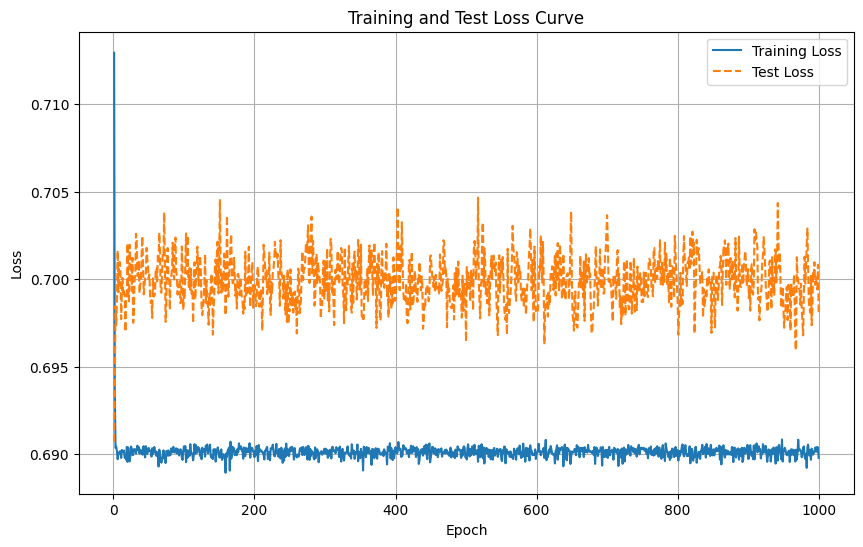

In [120]:
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, epochs + 1), test_loss, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

### Step 4: Hyperparameter Tuning   

In [121]:
#Optimizer
learning_rate =[0.001,0.01,0.05,0.1]
train_loss_per_lr = []

epochs = 1000

for lr in learning_rate:
    optimizer = optim.SGD(model.parameters(),lr = lr, weight_decay=0.001)
    train_loss= []
    for epoch in range(epochs):
        #training mode
        model.train()
        loss_ = 0
        for X_batch, Y_batch in train_loader:
            #prediction
            Y_hat = model(X_batch)
            #calculate loss
            loss = criterion(Y_hat, Y_batch.view(-1,1))
            loss_ += loss.item()
            #reset gradients
            optimizer.zero_grad()
            #calculate gradients
            loss.backward()
            #update parameters
            optimizer.step()
        train_loss.append(loss_/len(train_loader))
    train_loss_per_lr.append(np.mean(train_loss))    

print(train_loss_per_lr)

[0.6857957743237912, 0.690088792246431, 0.7043991507096589, 0.7211028186638653]


### Step 5: Model Optimization and Evaluation  

In [ ]:
#Optimizer
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(),lr = learning_rate, weight_decay=0.01)

train_loss = []
test_loss= []
epochs = 1000

for epoch in range(epochs):
    #training mode
    model.train()
    loss_ = 0
    for X_batch, Y_batch in train_loader:
        #prediction
        Y_hat = model(X_batch)
        #calculate loss
        loss = criterion(Y_hat, Y_batch.view(-1,1))
        loss_ += loss.item()
        #reset gradients
        optimizer.zero_grad()
        #calculate gradients
        loss.backward()
        #update parameters
        optimizer.step()
    train_loss.append(loss_/len(train_loader))

    #validation mode
    model.eval()
    loss_=0
    #no need to calculate gradients for test data
    with torch.no_grad():
        for X_test_batch, Y_test_batch in test_loader:
            #predict:
            Y_tets_hat = model(X_test_batch)
            loss = criterion(Y_tets_hat,Y_test_batch.view(-1,1))
            loss_ +=loss.item()
        test_loss.append(loss_/len(test_loader))

    if epoch%200==0 :
        print(f'For epoch {epoch}, training loss is {train_loss[-1]}, and test loss is {test_loss[-1]}.')

y_hat_train = model(X_train_scaled_tensor)
y_hat_test = model(X_test_scaled_tensor)
y_hat_train=torch.tensor([1.0 if (y_hat_train[i]>=0.5) else 0.0 for i in range(len(y_hat_train)) ])
y_hat_test=torch.tensor([1.0 if y_hat_test[i]>=0.5 else 0.0 for i in range(len(y_hat_test))])

# X_train_scaled_tensor,Y_train_tensor
train_metric = Accuracy()
train_metric.update_state(y_hat_train,Y_train_tensor)
test_metric = Accuracy()
test_metric.update_state(y_hat_test,Y_test_tensor)
print(f'Accuracy for training data is {train_metric.result()}, and for validation data is {test_metric.result()}')

For epoch 0, training loss is 0.6966000664234161, and test loss is 0.6984810322523117.
For epoch 200, training loss is 0.6901714606583118, and test loss is 0.6997538471221924.


### Step 6: Visualization and Interpretation  

#### Confusion Matrix : 
A Confusion Matrix is a fundamental tool used in classification problems to evaluate the performance of a model. It provides a matrix showing the number of correct and incorrect predictions made by the model, categorized by the actual and predicted classes.
Where 
-  True Positive (TP): Correctly predicted positive class (class 1).
- True Negative (TN): Correctly predicted negative class (class 0).
- False Positive (FP): Incorrectly predicted as positive (class 1), but the actual class is negative (class 0). This is also called a Type I error.
- False Negative (FN): Incorrectly predicted as negative (class 0), but the actual class is positive (class 1). This is also called a Type II error. 

#### ROC Curve (Receiver Operating Characteristic Curve):
The ROC Curve is a graphical representation used to evaluate the performance of a binary classification model across all classification thresholds. It plots two metrics:
- True Positive Rate (TPR) or Recall (Sensitivity)-It is the proportion of actual positive instances (class 1) that were correctly classified as positive by the model.
- False Positive Rate (FPR)-It is the proportion of actual negative instances (class 0) that were incorrectly classified as positive by the model.
  
##### AUC: 
AUC stands for Area Under the Curve and is a performance metric used to evaluate the quality of a binary classification model. Specifically, it refers to the area under the ROC curve (Receiver Operating Characteristic curve), which plots the True Positive Rate (TPR) versus the False Positive Rate (FPR) for different threshold values. A high AUC means the model is good at distinguishing classes.
* AUC = 1: Perfect classifier
* AUC = 0.5: Random guessing
* AUC > 0.7: Indicates good performance


#### Classification Report:
A Classification Report is a summary of various classification metrics, which are useful for evaluating the performance of a classifier on the given dataset.
* Precision: Indicates how many of the predicted positive cases are actually positive. High precision means low false positive rates (e.g., spam filtering),
* Recall: Indicates how many of the actual positive cases were correctly identified. High recall means low false negatives (e.g., cancer detection)
* F1-score: The harmonic mean of precision and recall, balancing the trade-off between them.
* Support: The number of true instances of each class in the dataset.

The weighted average at the bottom summarizes metrics across all classes, weighted by the number of samples in each class.


Confusion Matrix:
[[38 57]
 [42 63]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.47      0.40      0.43        95
         1.0       0.53      0.60      0.56       105

    accuracy                           0.51       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.50      0.51      0.50       200



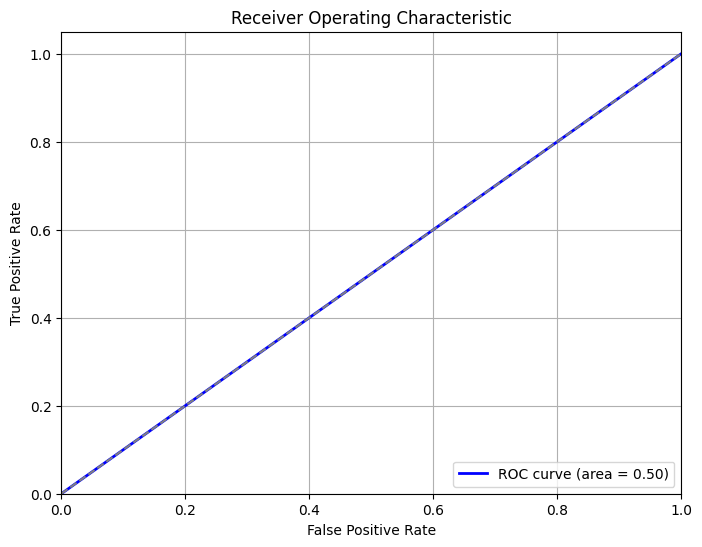

In [110]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Confusion matrix
cm = confusion_matrix(Y_test_tensor, y_hat_test)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(Y_test_tensor, y_hat_test)
print("\nClassification Report:")
print(report)

# Plot ROC curve
fpr, tpr, _ = roc_curve(Y_test_tensor, y_hat_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Step 7: Model Saving and Loading  

In [55]:
## Write your code here
# Save the model
torch.save(model.state_dict(),'./model')

# Load the model
model_new = LogisticRegressionModel(8,1)
#Load saved parameters
model_new.load_state_dict(torch.load('./model'))


# Ensure the loaded model is in evaluation mode
#evaluation model
model_new.eval()
loss_=0
#no need to calculate gradients for test data
with torch.no_grad():
    for X_test_batch, Y_test_batch in test_loader:
        #predict:
        Y_tets_hat = model(X_test_batch)
        loss = criterion(Y_tets_hat,Y_test_batch.view(-1,1))
        loss_ +=loss.item()
print(loss_)

69.82002401351929


/var/folders/8m/tdc0gjb14qq878phzzsj20l80000gn/T/ipykernel_66293/3210067626.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new.load_state_dict(torch.load('./model

### Step 8: Feature Importance  

       Features  Importance
0         kills    0.130444
1        deaths   -0.011673
2       assists   -0.029342
3   gold_earned    0.151682
4            cs    0.001288
5  wards_placed    0.114396
6  wards_killed   -0.029953
7  damage_dealt   -0.019349


/var/folders/8m/tdc0gjb14qq878phzzsj20l80000gn/T/ipykernel_66293/1987438577.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new.load_state_dict(torch.load('./mode

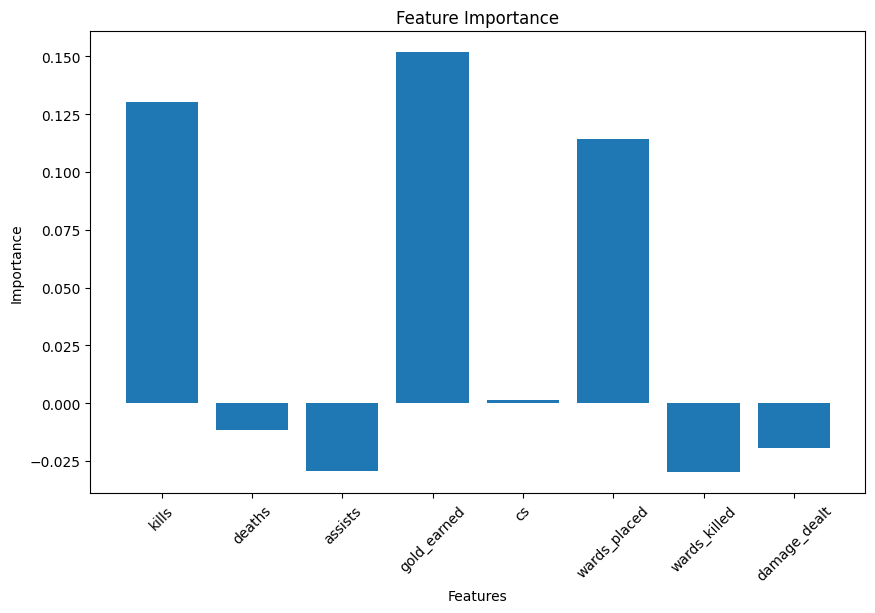

In [75]:
## Write your code here

import pandas as pd
import matplotlib.pyplot as plt

# Extract the weights of the linear layer
# Load the model
model_new = LogisticRegressionModel(8,1)
#Load saved parameters
model_new.load_state_dict(torch.load('./model'))
parameters = model_new.state_dict()['linear.weight']
bias = model_new.state_dict()['linear.bias']
# Create a DataFrame for feature importance
model_Parameters = pd.DataFrame({'Features':features.columns,'Importance':parameters.numpy()[0]})
print(model_Parameters)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(model_Parameters['Features'], model_Parameters['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()